# Histogramas de Gradientes ( cv2.calcHist )
# HOG Human<a class="tocSkip">
## Minería de Datos y Patrones <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**



# Ejemplo: Detección de Personas

En este ejercicio se realizará la detección de peatones usando HoG y un clasificador simple KNN.


**ADVERTENCIA:** Este ejercicio tiene fines pedagógicos sólamente, con la idea de que la solución a este problema pueda ejecutarse en un par de minutos. Un buen detector de personas sigue esta idea pero con miles de imágenes por clase.




# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Setup de librerías

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from   skimage.feature import local_binary_pattern
from   skimage.filters import gabor_kernel
from   sklearn.metrics import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier
from   tqdm.auto import tqdm
from   seaborn import heatmap
from IPython.display import clear_output
print('Librerías cargadas.')


Librerías cargadas.


## Funciones necesarias

In [11]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def imageload(prefix,num_class,digits_class,num_img,digits_img,sep='_',echo='off'):
  st   = prefix + num2fixstr(num_class,digits_class) + sep + num2fixstr(num_img,digits_img) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

def minmax(X):
  ma = X.max(0)
  mi = X.min(0)
  md    = ma-mi
  a     = 1/ md
  b     = -mi/md
  return X * a + b, a, b

def hog(img, orientations=9, pixels_per_cell=(16,16),cells_per_block=(2,2),norm=False):
  X = skimage.feature.hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block)
  if norm:
    X = X/np.linalg.norm(X)
  return X

# Separación entre training y testing
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = int(X.shape[0]/K)        # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training         
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing  

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1

  return Xtrain,ytrain,Xtest,ytest

# Clasificación usando KNN
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_neighbors=1,normalize=True,echo=True):
  if normalize:
    Xtrain, a, b = minmax(Xtrain)
    Xtest        = Xtest * a + b
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  C = confusion_matrix(ytest,ypred)
  if echo:
    print('Training with '+str(Xtrain.shape[0])+' samples. Testing with '+str(Xtest.shape[0])+' samples (of '+str(Xtrain.shape[1])+ ' features)...')
    print('Testing Accuracy = '+str(acc*100)+'%')
    print('Confusion Matrix:')
    print(C)
  return acc,C

# Ejemplo 1: Reconocimiento peatón vs no-peatón

* Clase 0: Personas (peatones)

* Clase 1: No-Personas (fotos de la partes de la ciudad sin personas)

La base de datos contiene 680 imágenes por clase de 160x96 pixeles en escala de grises.


## Carga de base de datos

La base de datos consiste en 2 clases y 120 imágenes por clase. Se almacenan en la carpeta facedetection con el formato face_xx_nnn.png, donde xx es el ID de la clase (01 para caras, 02 para no caras) y nnn es el número de la foto de la clase (01, 02, ... 120). Las fotos son de 160x96 pixeles.

In [12]:
!wget https://www.dropbox.com/s/3z11rt5ph1j08t2/persons.zip?dl=0
!unzip persons.zip
clear_output()
print('Base de datos personas/no-personas cargada.')

Base de datos personas/no-personas cargada.


Class Peatón:


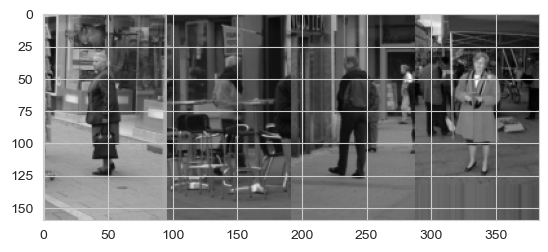


Class No-Peatón:


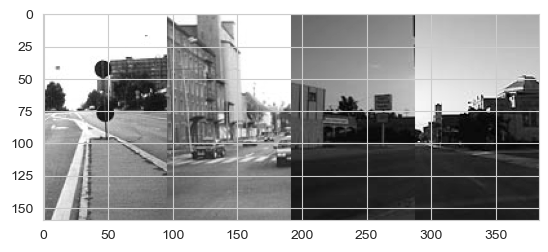

In [4]:
print('Class Peatón:')
I1    = 255*imageload('persons/person_',1,2,10,4)
I2    = 255*imageload('persons/person_',1,2,15,4)
I3    = 255*imageload('persons/person_',1,2,25,4)
I4    = 255*imageload('persons/person_',1,2,35,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()

print('')
print('Class No-Peatón:')
I1    = 255*imageload('persons/person_',2,2,10,4)
I2    = 255*imageload('persons/person_',2,2,15,4)
I3    = 255*imageload('persons/person_',2,2,25,4)
I4    = 255*imageload('persons/person_',2,2,35,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()


## Extracción de características HoG


Con el comando

`f  = hog(image, orientations=bn, pixels_per_cell, cells_per_block)`

se divide la imagen en `v` x `h` celdas, y a cada una de se le extrae un descriptor HoG de `b` bins. El descriptor f tiene `v*h*b` elementos.



In [5]:
K    = 2     # Number of classes
N    = 680   # Number of images per class
Mhog = 1620  # Number of elements of HoG vector

Xhog  = np.zeros((K*N,Mhog))    # K*N samples (rows), y Mlbp features (columns)

y     = np.zeros((K*N),'int')   # ground truth

bn    = 9
px    = 16
cl    = 2

t = 0
print('Loading images and extracting features...')
for j in range(K):            # for each class
  print('Extracting features: batch '+str(j+1)+'/'+str(K))
  for i in tqdm(range(N)):                # for each image of the class
    # Image
    img    = 255*imageload('persons/person_',j+1,2,i+1,4)

    # HoG
    Xhog[t,:] = hog(img, orientations=bn, pixels_per_cell=(px,px),cells_per_block=(cl,cl))
    y[t] = j # sample t belongs to class j
    t = t+1

Loading images and extracting features...
Extracting features: batch 1/2


  0%|          | 0/680 [00:00<?, ?it/s]

Extracting features: batch 2/2


  0%|          | 0/680 [00:00<?, ?it/s]

## Clasificación usando HoG

600 imágenes por clase para training y 80 imágenes por clase para testing.

Training with 1200 samples. Testing with 160 samples (of 1620 features)...
Testing Accuracy = 93.75%
Confusion Matrix:
[[77  3]
 [ 7 73]]


<Axes: >

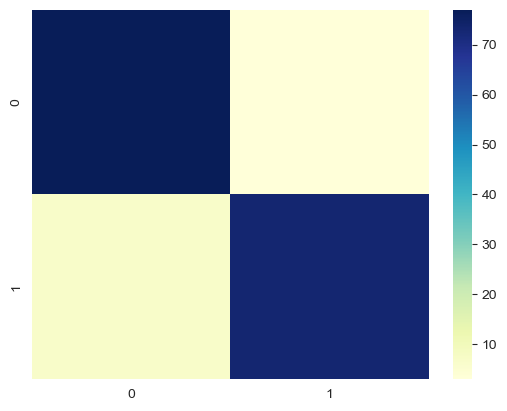

In [6]:
# Paso 1: definir X
X = Xhog

# Paso 2: separar training/testing
ntrain = 600 
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain) 

# Paso 3: clasificar y evaluar desempeño
acc,C = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)

heatmap(C, cmap="YlGnBu")

# Ejemplo 2: peatón - no-peatón - peatón con bicicleta


* Clase 0: Personas (peatones)

* Clase 1: No-Personas (fotos de la partes de la ciudad sin personas)

* Clase 2: Peatones con bicicleta


La base de datos contiene 254 imágenes por clase de 160x96 pixeles en escala de grises.


## Carga de base de datos

In [ ]:
!wget https://www.dropbox.com/s/pm9kyjtucsiiepf/bikes.zip?dl=0
!unzip bikes.zip
clear_output()
print('Base de datos personas/no-personas/personas con bicicletas cargada.')

Base de datos personas/no-personas/personas con bicicletas cargada.


Class Peatónn:


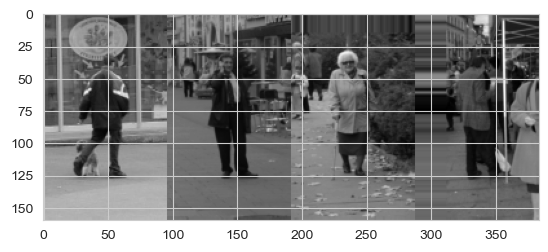


Clase No-Peatón:


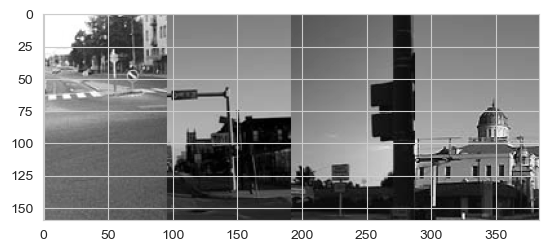


Clase Peatón-con-Bicicleta:


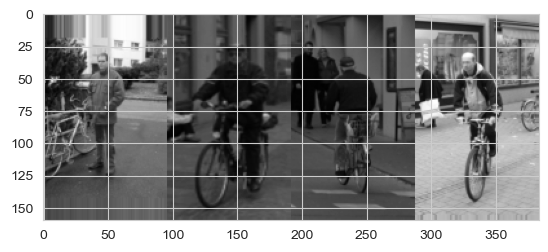

In [7]:
print('Class Peatónn:')
I1    = 255*imageload('bikes/person_',1,2, 7,4)
I2    = 255*imageload('bikes/person_',1,2,17,4)
I3    = 255*imageload('bikes/person_',1,2,27,4)
I4    = 255*imageload('bikes/person_',1,2,37,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()

print('')
print('Clase No-Peatón:')
I1    = 255*imageload('bikes/person_',2,2, 7,4)
I2    = 255*imageload('bikes/person_',2,2,17,4)
I3    = 255*imageload('bikes/person_',2,2,27,4)
I4    = 255*imageload('bikes/person_',2,2,37,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()

print('')
print('Clase Peatón-con-Bicicleta:')
I1    = 255*imageload('bikes/person_',3,2, 7,4)
I2    = 255*imageload('bikes/person_',3,2,17,4)
I3    = 255*imageload('bikes/person_',3,2,27,4)
I4    = 255*imageload('bikes/person_',3,2,37,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()


## Extracción de características HoG

In [8]:
K    = 3
N    = 254
Xhog = np.zeros((K*N,Mhog))
y    = np.zeros((K*N),'int')
t    = 0
for j in range(K):
  for i in tqdm(range(N)):
    img       = 255*imageload('bikes/person_',j+1,2,i+1,4)
    Xhog[t,:] = hog(img, orientations=bn, pixels_per_cell=(px,px),cells_per_block=(cl,cl))
    y[t]      = j
    t         = t+1

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

## Clasificación usando HoG

230 imágenes por clase para training y 24 imágenes por clase para testing.

Training with 690 samples. Testing with 72 samples (of 1620 features)...
Testing Accuracy = 80.55555555555556%
Confusion Matrix:
[[19  5  0]
 [ 1 18  5]
 [ 3  0 21]]


<Axes: >

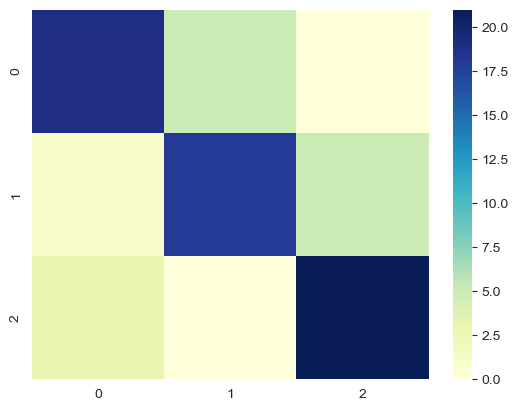

In [9]:
X      = Xhog
ntrain = 230
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain)
acc,C  = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)
heatmap(C, cmap="YlGnBu")

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).